In [1]:
import pandas as pd
from collections import Counter
import spacy
import numpy as np
import matplotlib
import string

In [2]:
%pwd

'/Users/lukachabaud/Desktop/TFG/Project'

First we load the data into a dataframe

In [3]:
DATA_PATH = "data/Tatoeba Corpus/ca-es.txt/Tatoeba.ca-es.ca"

with open(DATA_PATH, "r") as fp:
    lines = fp.readlines()
    prep_lines = [line.replace(" \n", "") for line in lines]
    df = pd.DataFrame(prep_lines, columns=["sentences"])
    
display(df)

,sentences
0,Provem quelcom!
1,Provem alguna cosa!
2,A vegades pot ser un noi estrany.
3,Aixo depen del contexte
4,Això depèn del context.
...,...
2854,Li va cantar una canço.
2855,En algunes llunes d'aquell gegant de gas hi ha...
2856,Quantes preguntes has contestat?
2857,Plou a bots i barrals.


In [4]:
from typing import Iterable

def remove_punctuation(sentence: str) -> str:
    # Use str.maketrans to create a translation table
    translator = str.maketrans("", "", string.punctuation)

    # Use translate to remove punctuation
    sentence_without_punctuation = sentence.translate(translator)

    return sentence_without_punctuation

def preprocess(sentences: Iterable[str]) -> pd.Series:
    """Applies preprocessing to the raw sentences

    Args:
        sentences (Iterable[str]): the sentences to preprocess

    Returns:
        pd.Series: the preprocessed sentences
    """
    
    return pd.Series([sent.split() for sent in sentences])

In [5]:
df["tokenized_sentences"] = preprocess(df["sentences"])
df["word_count"] = [len(tokens) for tokens in df["tokenized_sentences"]]
df.head()

,sentences,tokenized_sentences,word_count
0,Provem quelcom!,"[Provem, quelcom!]",2
1,Provem alguna cosa!,"[Provem, alguna, cosa!]",3
2,A vegades pot ser un noi estrany.,"[A, vegades, pot, ser, un, noi, estrany.]",7
3,Aixo depen del contexte,"[Aixo, depen, del, contexte]",4
4,Això depèn del context.,"[Això, depèn, del, context.]",4


We will drop the sentences that have less than a certain number of words, as they may not be enough to create meaningful synthetic glosses.

In [6]:
MIN_WORDS = 3
purged_df = df[df["word_count"] >= MIN_WORDS]
purged_df["tokenized_sentences"] = purged_df["tokenized_sentences"].apply(tuple)
purged_df = purged_df.drop_duplicates()
purged_df["tokenized_sentences"] = purged_df["tokenized_sentences"].apply(list)
#purged_df = purged_df.drop(columns=["word_count"])
display(purged_df)

/var/folders/6l/9d78p88n5r55d3bft80dmb6c0000gn/T/ipykernel_84505/3336956861.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purged_df["tokenized_sentences"] = purged_df["tokenized_sentences"].apply(tuple)


,sentences,tokenized_sentences,word_count
1,Provem alguna cosa!,"[Provem, alguna, cosa!]",3
2,A vegades pot ser un noi estrany.,"[A, vegades, pot, ser, un, noi, estrany.]",7
3,Aixo depen del contexte,"[Aixo, depen, del, contexte]",4
4,Això depèn del context.,"[Això, depèn, del, context.]",4
5,Això seria una cosa que caldria programar,"[Això, seria, una, cosa, que, caldria, programar]",7
...,...,...,...
2853,Pots esborrar aquesta foto?,"[Pots, esborrar, aquesta, foto?]",4
2854,Li va cantar una canço.,"[Li, va, cantar, una, canço.]",5
2855,En algunes llunes d'aquell gegant de gas hi ha...,"[En, algunes, llunes, d'aquell, gegant, de, ga...",14
2856,Quantes preguntes has contestat?,"[Quantes, preguntes, has, contestat?]",4


Let's see which words are the most frequent

In [7]:
#First we want to obtain all the words in a list
all_sentences = " ".join(purged_df["sentences"])
all_words = all_sentences.split()

#Create a counter object
word_counter = Counter(all_words)

#Convert it into a dataframe
word_counts_df = pd.DataFrame(list(word_counter.items()), columns=["Word", "Count"])
word_counts_df = word_counts_df.sort_values(by='Count', ascending=False)

#Display the results
word_counts_df.head(10)

,Word,Count
81,la,525
63,a,499
135,de,498
20,que,448
29,el,413
36,és,348
175,va,296
113,no,269
7,un,260
43,No,216


We can compute the average sentence length and the variance

In [8]:
avg_sent_len = np.mean([len(sent) for sent in purged_df["tokenized_sentences"]])
print(f"The average sentence length is {avg_sent_len:.3}")

var_sent_len = np.var([len(sent) for sent in purged_df["tokenized_sentences"]])
print(f"The variance of the sentence length is {var_sent_len:.3}")


The average sentence length is 7.24
The variance of the sentence length is 16.0


In [9]:
purged_df.describe(include="all")

,sentences,tokenized_sentences,word_count
count,2678,2678,2678.000000
unique,2678,2678,NaN
top,Provem alguna cosa!,"[Provem, alguna, cosa!]",NaN
freq,1,1,NaN
mean,NaN,NaN,7.240851
std,NaN,NaN,3.998396
min,NaN,NaN,3.000000
25%,NaN,NaN,5.000000
50%,NaN,NaN,7.000000
75%,NaN,NaN,9.000000


<Axes: >

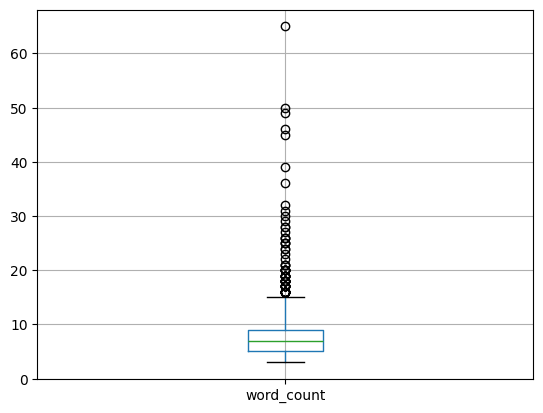

In [10]:
purged_df.boxplot("word_count")

In [11]:
purged_df.sort_values(by="word_count", ascending=False).head()

,sentences,tokenized_sentences,word_count
663,"I encara que ja no estigui entre nosaltres, sé...","[I, encara, que, ja, no, estigui, entre, nosal...",65
2655,És insultant que us penseu que les persones LG...,"[És, insultant, que, us, penseu, que, les, per...",50
770,Si hi ha algú allà fora que encara dubta de Am...,"[Si, hi, ha, algú, allà, fora, que, encara, du...",49
2182,Aquest és el noi que va jugar amb la joguina q...,"[Aquest, és, el, noi, que, va, jugar, amb, la,...",46
664,"Un astut caçador, Cristóbal Colón, una vegada ...","[Un, astut, caçador,, Cristóbal, Colón,, una, ...",45


In [12]:
nlp = spacy.load("ca_core_news_trf")
doc = nlp("Tinc una casa")
print([(w.text, w.pos_) for w in doc])

/Users/lukachabaud/Desktop/TFG/Project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[('Tinc', 'VERB'), ('una', 'NUM'), ('casa', 'NOUN')]


In [13]:
print([(w.text, w.pos_) for w in nlp("Tinc una casa que no té piscina.")])

[('Tinc', 'VERB'), ('una', 'DET'), ('casa', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('té', 'VERB'), ('piscina', 'NOUN'), ('.', 'PUNCT')]


In [14]:
from synthesize_glosses import generate_synthetic_glosses

generate_synthetic_glosses(nlp, "Tinc una casa que no té piscina.")

[('Tinc', 'VERB'), ('casa', 'NOUN'), ('no', 'ADV'), ('té', 'VERB'), ('piscina', 'NOUN')]
[('Tinc', 'VERB'), ('casa', 'NOUN'), ('no', 'ADV'), ('té', 'VERB'), ('piscina', 'NOUN')]
[('casa', 'NOUN'), ('piscina', 'NOUN'), ('no', 'ADV'), ('té', 'VERB'), ('Tinc', 'VERB')]


'CASA PISCINA NO TENIR TENIR'